BERT, Med + 2e-5 + oversampled + 15b epochs

In [1]:
name = "bert_oversampled_med_epoch_15"

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


train_data = pd.read_csv('../datasets/data_train.csv').dropna(subset=["data"])
test_data = pd.read_csv('../datasets/data_test.csv').dropna(subset=["data"])
valid_data = pd.read_csv('../datasets/data_valid.csv').dropna(subset=["data"])

train_data

all_labels = pd.concat([train_data["label"], test_data["label"], valid_data["label"]])
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

LabelEncoder()

In [3]:
# len(train_data) + len(test_data) + len(valid_data) = 38858
# df = train_data[train_data['data'].isna()]
# df

In [4]:
def extract_texts_labels(data, label_encoder):
    texts = data['data'].values
    labels = data['label'].values
    encoded_labels = label_encoder.transform(labels)
    return texts, encoded_labels

In [5]:
from sklearn.utils import shuffle

df = train_data.copy()

print("Original Class Distribution:")
print(df['label'].value_counts())

# Specify minority classes directly
minority_labels = ['cruciate-ligament-minor', 'cruciate-ligament-urgent', 'meniscus-minor']

# Calculate the number of samples needed to match the most populous class
class_counts = df['label'].value_counts()
majority_class_count = class_counts.max()

# Initialize an empty dataframe to collect oversampled data
oversampled_dfs = [df]

for label in minority_labels:
    minority_df = df[df['label'] == label]
    required_samples = majority_class_count - class_counts[label]
    replication_factor = required_samples // len(minority_df)  # Calculate replication factor
    oversampled_minority_df = pd.concat([minority_df] * replication_factor, ignore_index=True)
    oversampled_dfs.append(oversampled_minority_df)

# Combine the original dataframe with the oversampled minority dataframes
balanced_df = pd.concat(oversampled_dfs, ignore_index=True)

# Shuffle the dataset
balanced_df = shuffle(balanced_df, random_state=42)

train_data = balanced_df.copy()

print("New Class Distribution After Shuffling:")
print(balanced_df['label'].value_counts())

Original Class Distribution:
label
other-minor                 9698
meniscus-urgent             9226
cruciate-ligament-urgent    2382
meniscus-minor              1663
cruciate-ligament-minor      355
Name: count, dtype: int64
New Class Distribution After Shuffling:
label
other-minor                 9698
cruciate-ligament-minor     9585
cruciate-ligament-urgent    9528
meniscus-urgent             9226
meniscus-minor              8315
Name: count, dtype: int64


In [6]:
train_texts, train_labels = extract_texts_labels(train_data, label_encoder)
test_texts, test_labels = extract_texts_labels(test_data, label_encoder)
valid_texts, valid_labels = extract_texts_labels(valid_data, label_encoder)


In [7]:
from transformers import BertTokenizer

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("GerMedBERT/medbert-512")

# Tokenize the data
train_encodings = tokenizer(train_texts.astype(str).tolist(), truncation=True, padding='max_length', max_length=400)
test_encodings = tokenizer(test_texts.astype(str).tolist(), truncation=True, padding='max_length', max_length=400)
valid_encodings = tokenizer(valid_texts.astype(str).tolist(), truncation=True, padding='max_length', max_length=400)

In [8]:
import tensorflow as tf

def create_dataset(encodings, labels):
    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        labels
    ))
    return dataset

train_dataset = create_dataset(train_encodings, train_labels)
test_dataset = create_dataset(test_encodings, test_labels)
valid_dataset = create_dataset(valid_encodings, valid_labels)

2024-08-05 00:34:27.606365: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-08-05 00:34:27.606391: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-08-05 00:34:27.606395: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-08-05 00:34:27.606412: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-05 00:34:27.606423: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
from transformers import TFBertForSequenceClassification

# Load the BERT model for sequence classification with the number of output labels
model = TFBertForSequenceClassification.from_pretrained("GerMedBERT/medbert-512", num_labels=len(label_encoder.classes_))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=4e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[ "accuracy" ]
)


In [11]:
# Train the model with early stopping callback
model.fit(train_dataset.shuffle(1000).batch(64),
          validation_data=valid_dataset.batch(64),
          epochs=15)


Epoch 1/15


2024-08-05 00:34:54.058155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


365/365 [==============================] - 1541s 4s/step - loss: 1.1486 - accuracy: 0.4802 - val_loss: 1.1085 - val_accuracy: 0.5028
Epoch 2/15
365/365 [==============================] - 1521s 4s/step - loss: 1.0643 - accuracy: 0.5347 - val_loss: 1.0754 - val_accuracy: 0.5307
Epoch 3/15
365/365 [==============================] - 1516s 4s/step - loss: 0.9810 - accuracy: 0.5889 - val_loss: 1.0781 - val_accuracy: 0.5577
Epoch 4/15
365/365 [==============================] - 1514s 4s/step - loss: 0.8536 - accuracy: 0.6560 - val_loss: 1.0480 - val_accuracy: 0.5897
Epoch 5/15
365/365 [==============================] - 1512s 4s/step - loss: 0.7115 - accuracy: 0.7244 - val_loss: 1.0678 - val_accuracy: 0.6165
Epoch 6/15
365/365 [==============================] - 1510s 4s/step - loss: 0.5859 - accuracy: 0.7746 - val_loss: 1.1289 - val_accuracy: 0.6293
Epoch 7/15
365/365 [==============================] - 1509s 4s/step - loss: 0.4741 - accuracy: 0.8195 - val_loss: 1.0617 - val_accuracy: 0.6677
Epo

In [12]:
# Evaluate the model
loss, accuracy = model.evaluate(test_dataset.batch(32))
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

243/243 [==============================] - 143s 583ms/step - loss: 1.1520 - accuracy: 0.7486
Loss: 1.1519508361816406
Accuracy: 0.7485515475273132


In [13]:
model.save_pretrained(name)
tokenizer.save_pretrained(name + "_tokenizer")

('bert_oversampled_med_epoch_15_tokenizer/tokenizer_config.json',
 'bert_oversampled_med_epoch_15_tokenizer/special_tokens_map.json',
 'bert_oversampled_med_epoch_15_tokenizer/vocab.txt',
 'bert_oversampled_med_epoch_15_tokenizer/added_tokens.json')

In [14]:
import numpy as np
predictions = model.predict(test_dataset.batch(32))
predicted_labels = np.argmax(predictions.logits, axis=-1)

# Decode class labels to original labels
decoded_predictions = label_encoder.inverse_transform(predicted_labels)

# True labels from the test set
true_labels = label_encoder.inverse_transform(test_labels)

# Create a DataFrame to compare
comparison_df = pd.DataFrame({'Text': test_texts, 'True Label': true_labels, 'Predicted Label': decoded_predictions})

243/243 [==============================] - 143s 572ms/step


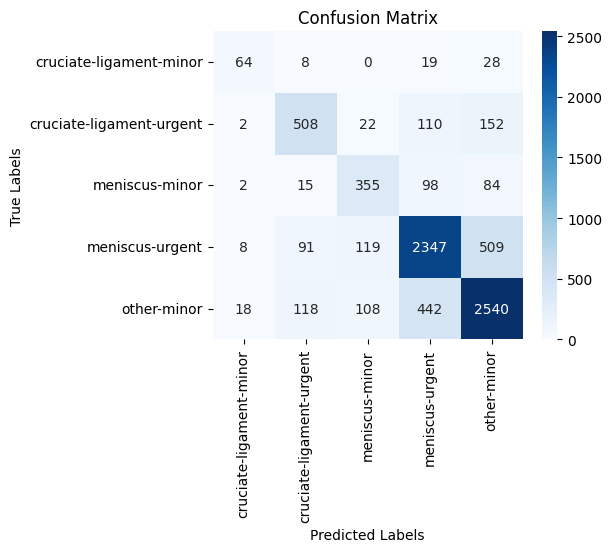

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels, decoded_predictions, labels=label_encoder.classes_)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [16]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, decoded_predictions, target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

 cruciate-ligament-minor       0.68      0.54      0.60       119
cruciate-ligament-urgent       0.69      0.64      0.66       794
          meniscus-minor       0.59      0.64      0.61       554
         meniscus-urgent       0.78      0.76      0.77      3074
             other-minor       0.77      0.79      0.78      3226

                accuracy                           0.75      7767
               macro avg       0.70      0.67      0.68      7767
            weighted avg       0.75      0.75      0.75      7767



In [17]:
from sklearn.metrics import classification_report
report = classification_report(true_labels, decoded_predictions, target_names=label_encoder.classes_, output_dict=True)

In [18]:
df = pd.DataFrame(report).transpose()
df.to_csv(name + "_report.csv")